# U-net

Segmentación semántica

<img src="https://db0dce98.rocketcdn.me/es/files/2021/05/u-net-architecture-1024x682.png" width="75%">

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from torchvision.io import read_file, decode_jpeg, decode_png, ImageReadMode
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# DATASET
import os

# read dataset for u-net
class Dataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.files = [os.path.splitext(f)[0] for f in os.listdir(data_dir)]
        self.transform = T.Resize((512, 512))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name = self.files[idx]
        # read image
        image = read_image(os.path.join(self.data_dir, file_name + ".png"), mode=ImageReadMode.RGB)

        # read mask
        mask = read_image(os.path.join(self.label_dir, file_name + ".png"), mode=ImageReadMode.GRAY)

        # resize
        image = self.transform(image)
        mask = self.transform(mask)

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        image = image / 255.0
        mask /= 255.0
        mask = torch.round(mask)

        return image, mask

def detect_classes(label_dir):
    classes = set()
    for label_file in os.listdir(label_dir):
        # Leer la máscara
        mask = read_image(os.path.join(label_dir, label_file), mode=ImageReadMode.GRAY)
        # Agregar valores únicos a las clases detectadas
        classes.update(torch.unique(mask).tolist())
    return sorted(classes)  # Retorna las clases ordenadas

label_dir = "/content/drive/My Drive/unet/Unet/labels"
classes = detect_classes(label_dir)


ds_train = Dataset("/content/drive/My Drive/unet/Unet/images", "/content/drive/My Drive/unet/Unet/labels")
ds_loader_train = DataLoader(ds_train, batch_size=4)

ds_test = Dataset("/content/drive/My Drive/unet/Unet/test", "/content/drive/My Drive/unet/Unet/labels")
ds_loader_test = DataLoader(ds_test, batch_size=4)

In [4]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p # la salida del skip y la del maxpooling

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1) # concatena el skip con la entrada
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self,classes):
        super().__init__()
        self.classes = classes

        """ Encoder """
        self.e1 = encoder_block(3, 64) # 3 canales pq es una imagen a color
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0) # clasifica entre fondo y moneda, por eso pasa de 64 a 1 canal

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 512, 512)).to(device)
model = build_unet(classes=classes).to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 512, 512])


In [5]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = (outputs > 0.5).float()
        labels_binary = (labels > 0.5).float()

        correct += (predicted == labels_binary).sum().item()
        total += labels.numel()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            predicted = (outputs > 0.5).float()
            labels_binary = (labels > 0.5).float()

            # Calcular precisión
            correct += (predicted == labels_binary).sum().item()
            total += labels.numel()

            # Guardar etiquetas y predicciones para análisis posterior
            all_labels.extend(labels.cpu().numpy())  # Mover a CPU para métricas adicionales
            all_preds.extend(predicted.cpu().numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds



def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):

    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()



def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1, device=device):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Epoch 1, Training Loss: 0.2520524859428406, Training Accuracy: 68.87569427490234%
Epoch 1, Test Loss: 0.08417043089866638, Test Accuracy: 90.76366424560547%
Epoch 2, Training Loss: 0.5332514643669128, Training Accuracy: 59.52720642089844%
Epoch 2, Test Loss: 0.08314996212720871, Test Accuracy: 90.76366424560547%
Epoch 3, Training Loss: 0.19830204546451569, Training Accuracy: 79.52003479003906%
Epoch 3, Test Loss: 0.08444848656654358, Test Accuracy: 90.76366424560547%
Epoch 4, Training Loss: 0.10433049499988556, Training Accuracy: 89.25676345825195%
Epoch 4, Test Loss: 0.08727860450744629, Test Accuracy: 90.76366424560547%
Epoch 5, Training Loss: 0.07095956057310104, Training Accuracy: 95.12166976928711%
Epoch 5, Test Loss: 0.09290792047977448, Test Accuracy: 90.76366424560547%
Epoch 6, Training Loss: 0.0414738804101944, Training Accuracy: 96.78916931152344%
Epoch 6, Test Loss: 0.10019629448652267, Test Accuracy: 90.76366424560547%
Epoch 7, Training Loss: 0.03729121387004852, Training A

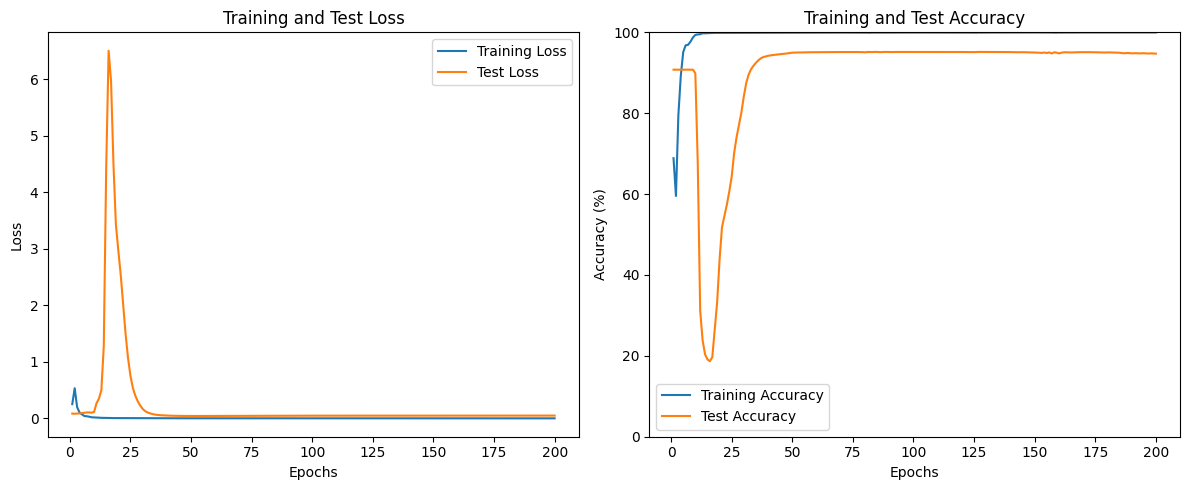

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
trained_model = train_model(model, ds_loader_train, ds_loader_test, criterion, optimizer, [], epochs=200)

<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


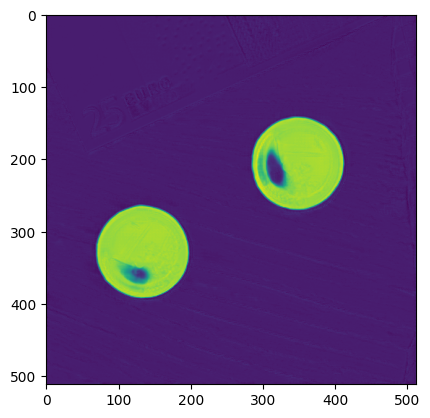

In [7]:
it = iter(ds_loader_test)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())

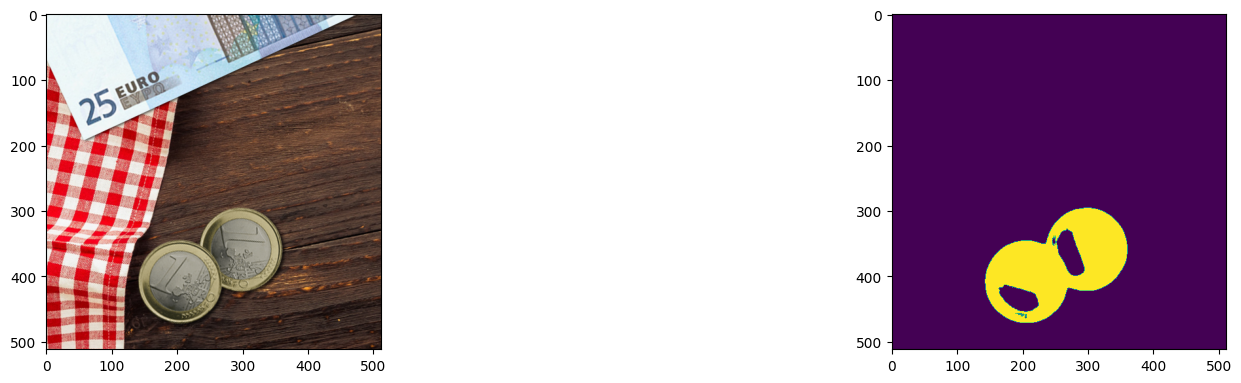

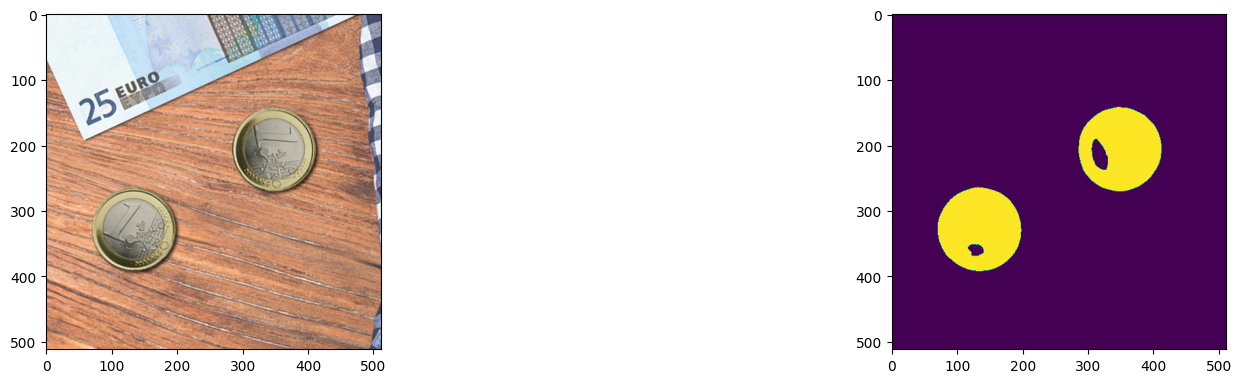

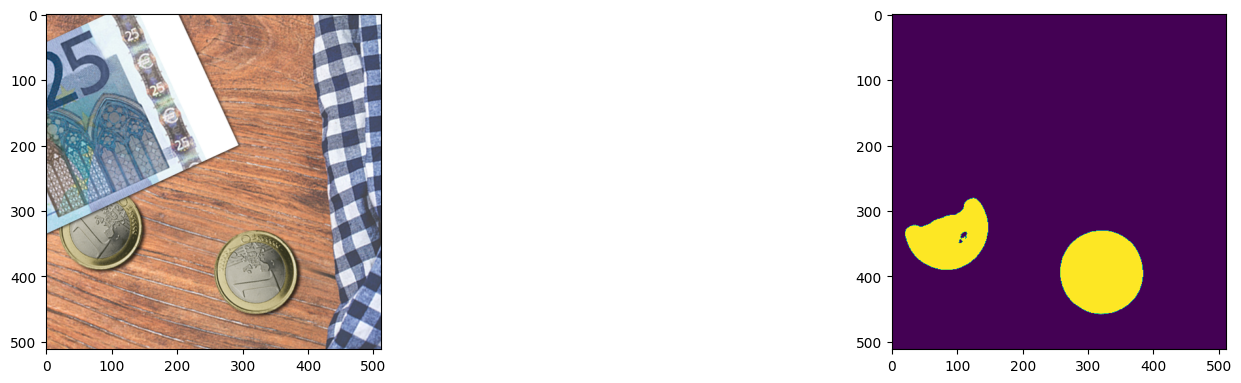

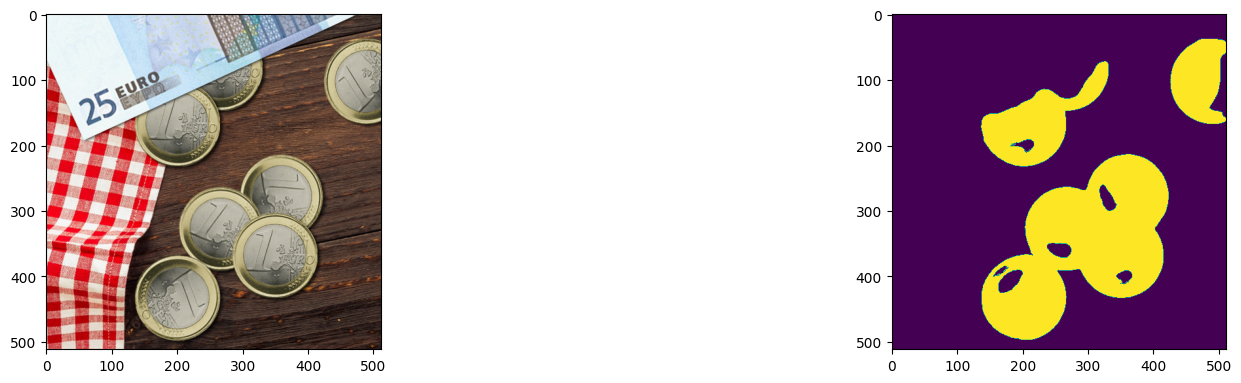

In [8]:

# Threshold the output
ret = torch.round(ret) # redondea para que sea 0 o 1

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())


In [9]:
torch.save(model.state_dict(), "/content/drive/My Drive/unet/Unet/model_unet_coins.pth")


In [10]:
#model = build_unet()
model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins.pth"))

<ipython-input-10-e55a7cf1f7c2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins.pth"))


<All keys matched successfully>

## Reducir el número de canales

In [11]:
class build_unet_dynamic(nn.Module):
    def __init__(self, channels, classes):
        """
        channels: Lista de canales para cada capa en el encoder y decoder.
        Ejemplo: [32, 64, 128, 256, 512]
        """
        super().__init__()
        self.classes = classes

        """ Encoder """
        self.e1 = encoder_block(3, channels[0])  # 3 canales de entrada (imagen a color)
        self.e2 = encoder_block(channels[0], channels[1])
        self.e3 = encoder_block(channels[1], channels[2])
        self.e4 = encoder_block(channels[2], channels[3])

        """ Bottleneck """
        self.b = conv_block(channels[3], channels[4])

        """ Decoder """
        self.d1 = decoder_block(channels[4], channels[3])
        self.d2 = decoder_block(channels[3], channels[2])
        self.d3 = decoder_block(channels[2], channels[1])
        self.d4 = decoder_block(channels[1], channels[0])

        """ Classifier """
        self.outputs = nn.Conv2d(channels[0], 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs


torch.Size([2, 1, 512, 512])


<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Epoch 1, Training Loss: 0.24939364194869995, Training Accuracy: 86.07664108276367%
Epoch 1, Test Loss: 0.11876320093870163, Test Accuracy: 90.76366424560547%
Epoch 2, Training Loss: 0.16913729906082153, Training Accuracy: 87.30611801147461%
Epoch 2, Test Loss: 0.11793380975723267, Test Accuracy: 90.76366424560547%
Epoch 3, Training Loss: 0.10163035988807678, Training Accuracy: 91.31860733032227%
Epoch 3, Test Loss: 0.11658146977424622, Test Accuracy: 90.76366424560547%
Epoch 4, Training Loss: 0.07496069371700287, Training Accuracy: 93.34754943847656%
Epoch 4, Test Loss: 0.11366860568523407, Test Accuracy: 90.76366424560547%
Epoch 5, Training Loss: 0.06709907948970795, Training Accuracy: 95.64981460571289%
Epoch 5, Test Loss: 0.10924787074327469, Test Accuracy: 90.76366424560547%
Epoch 6, Training Loss: 0.041852161288261414, Training Accuracy: 97.44224548339844%
Epoch 6, Test Loss: 0.1046823114156723, Test Accuracy: 90.76366424560547%
Epoch 7, Training Loss: 0.03115670569241047, Trainin

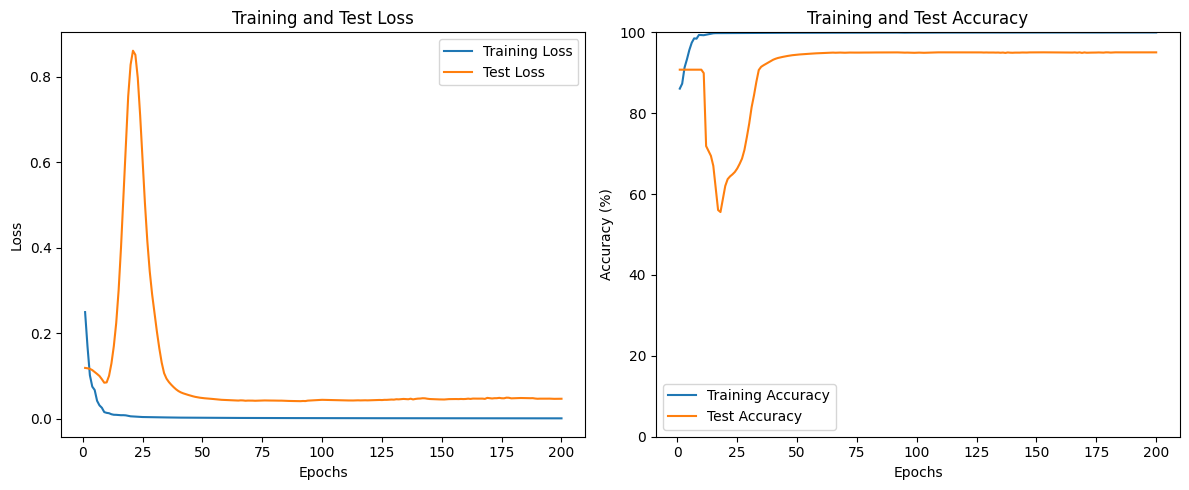

<ipython-input-12-9cb6f334b12c>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_0.pth"

<All keys matched successfully>

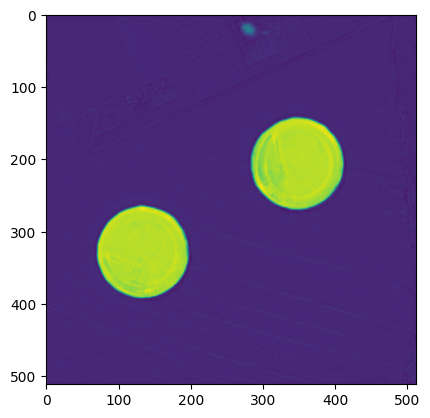

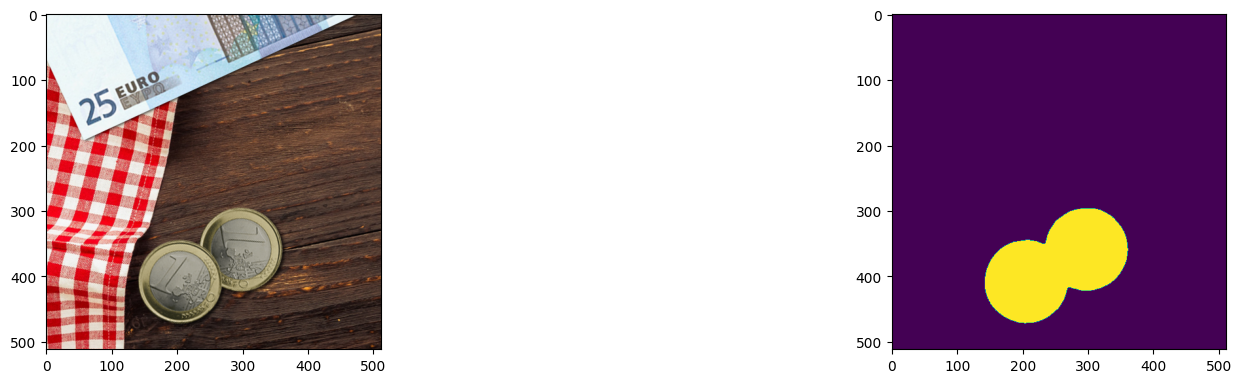

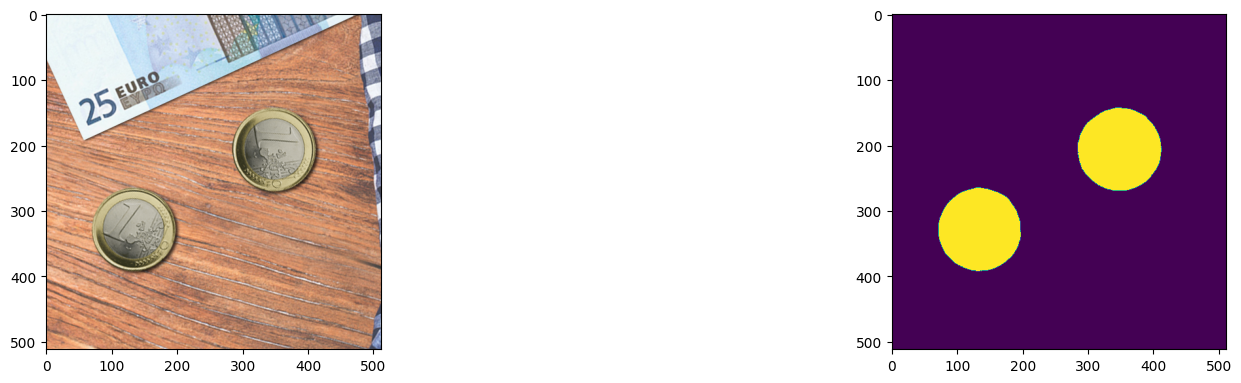

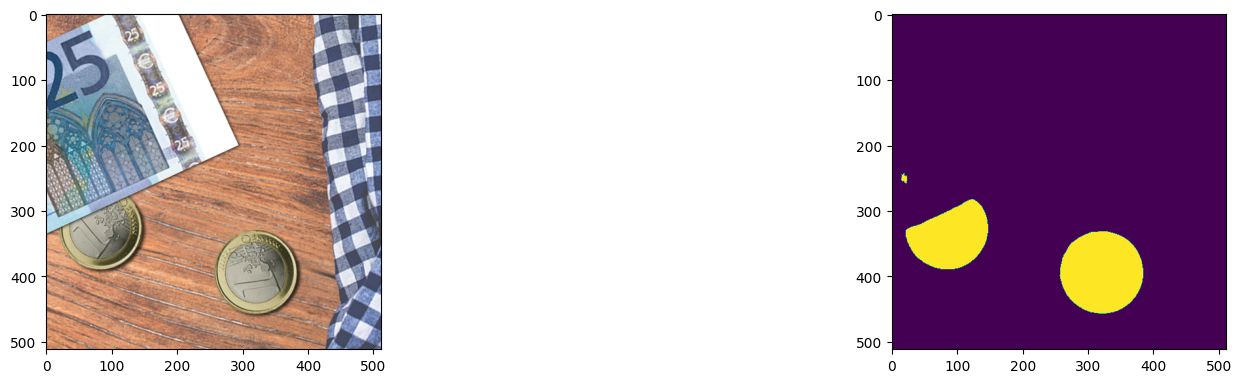

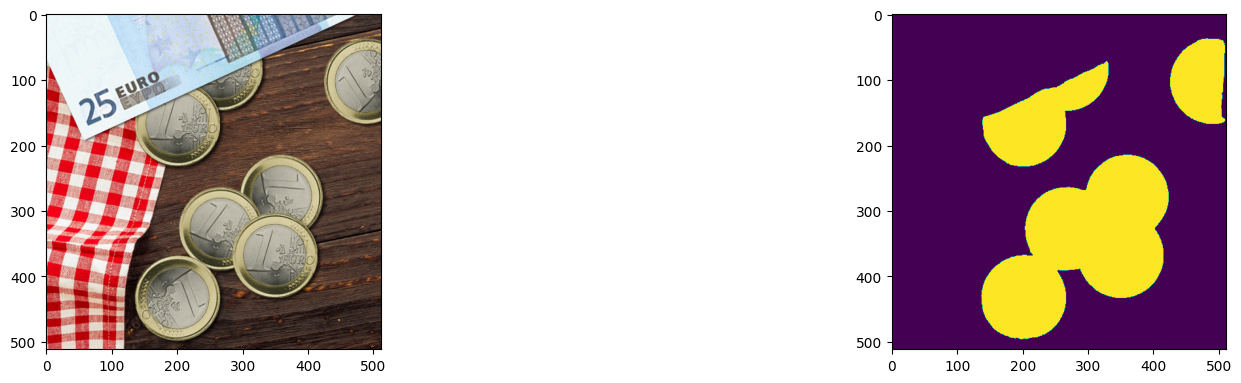

In [12]:
# Lista de configuraciones de canales
configurations = [
    [32, 64, 128, 256, 512],
    [16, 32, 64, 128, 256],
    [8, 16, 32, 64, 128],
    [4, 8, 16, 32, 64],
]

model = build_unet_dynamic(channels=configurations[0],classes=classes).to(device)
y = model(inputs)
print(y.shape)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
trained_model = train_model(model, ds_loader_train, ds_loader_test, criterion, optimizer, [], epochs=200)

it = iter(ds_loader_test)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())


# Threshold the output
ret = torch.round(ret) # redondea para que sea 0 o 1

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())

torch.save(model.state_dict(), "/content/drive/My Drive/unet/Unet/model_unet_coins_0.pth")
model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_0.pth"))


torch.Size([2, 1, 512, 512])


<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Epoch 1, Training Loss: 0.2541313171386719, Training Accuracy: 80.23643493652344%
Epoch 1, Test Loss: 0.101715087890625, Test Accuracy: 90.76366424560547%
Epoch 2, Training Loss: 0.16661036014556885, Training Accuracy: 85.27841567993164%
Epoch 2, Test Loss: 0.1031997948884964, Test Accuracy: 90.76366424560547%
Epoch 3, Training Loss: 0.12947136163711548, Training Accuracy: 87.01715469360352%
Epoch 3, Test Loss: 0.10424284636974335, Test Accuracy: 90.76366424560547%
Epoch 4, Training Loss: 0.10218674689531326, Training Accuracy: 89.10083770751953%
Epoch 4, Test Loss: 0.10500523447990417, Test Accuracy: 90.76366424560547%
Epoch 5, Training Loss: 0.0773581713438034, Training Accuracy: 91.61138534545898%
Epoch 5, Test Loss: 0.10574746131896973, Test Accuracy: 90.76366424560547%
Epoch 6, Training Loss: 0.05586397275328636, Training Accuracy: 94.42129135131836%
Epoch 6, Test Loss: 0.1066935658454895, Test Accuracy: 90.76366424560547%
Epoch 7, Training Loss: 0.040611013770103455, Training Acc

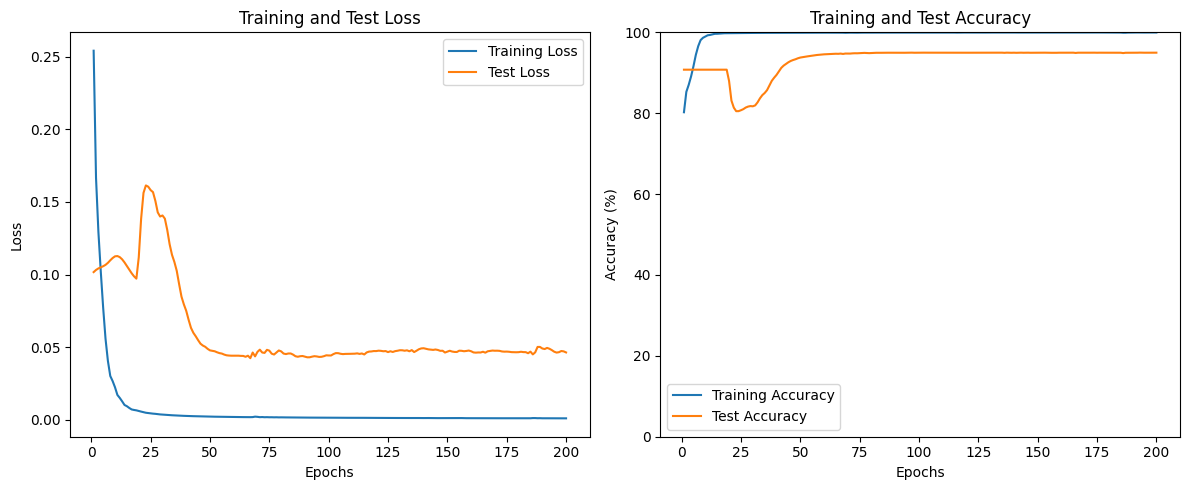

<ipython-input-13-b19ba180514a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_1.pth"

<All keys matched successfully>

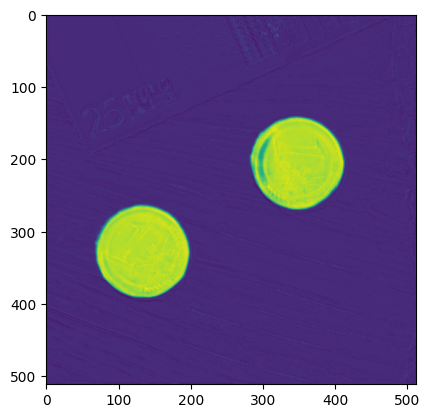

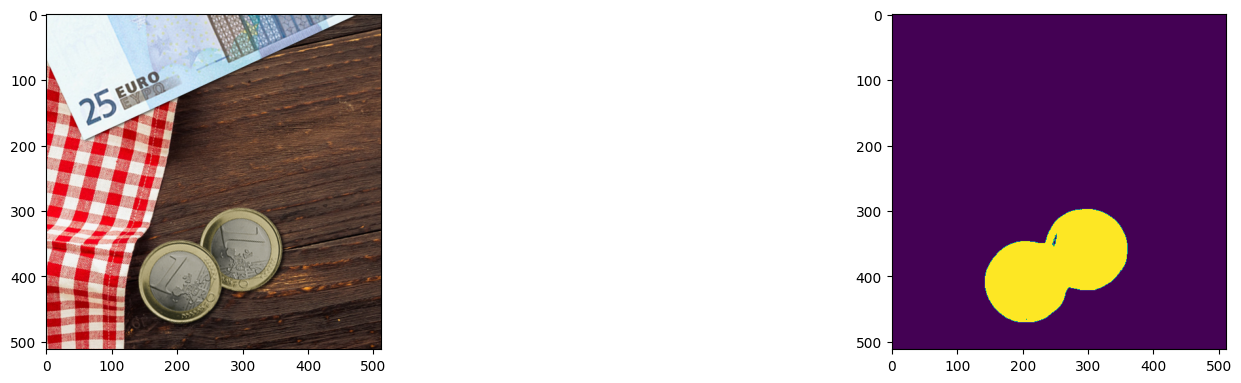

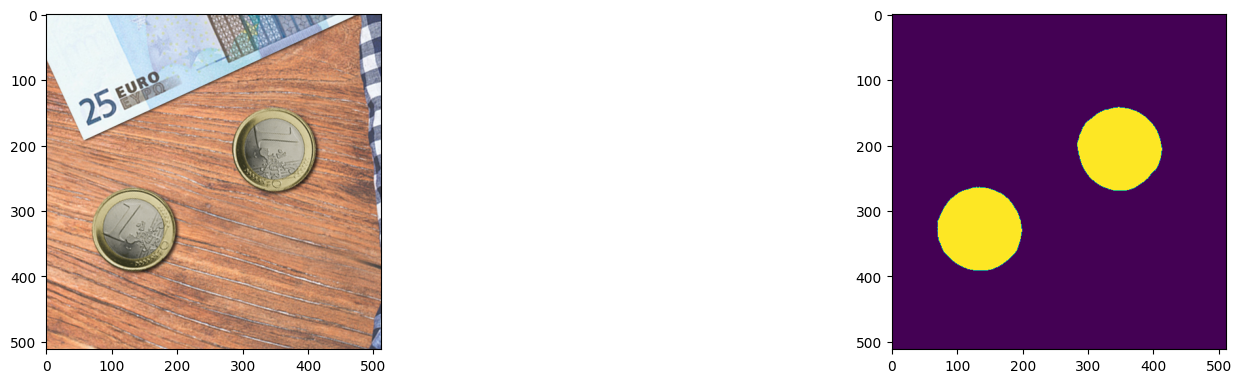

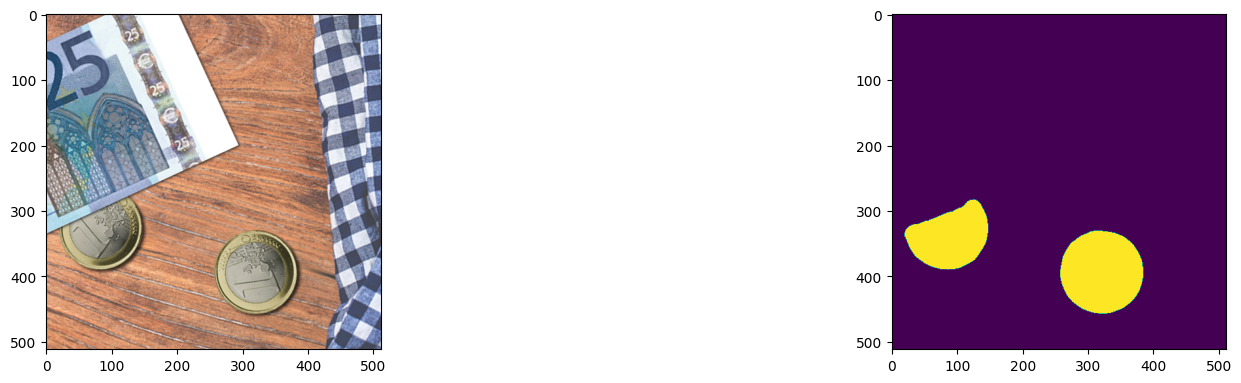

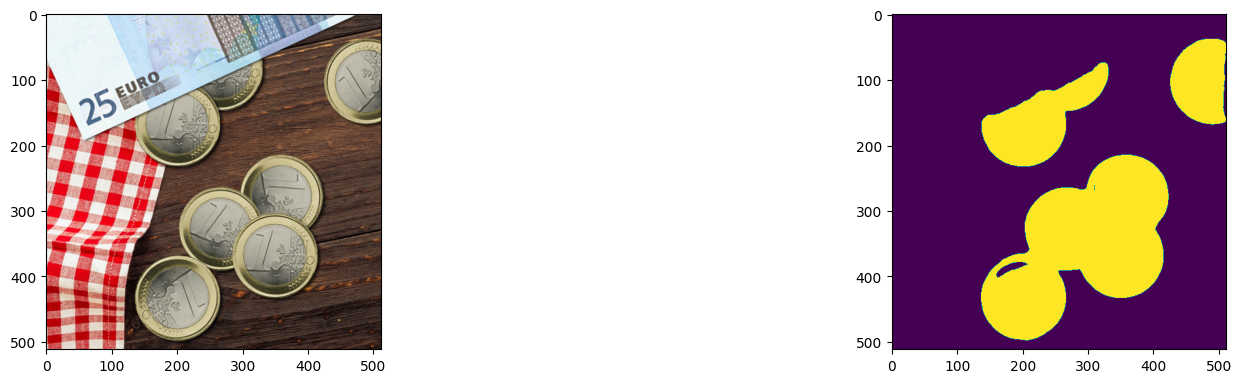

In [13]:
model = build_unet_dynamic(channels=configurations[1],classes=classes).to(device)
y = model(inputs)
print(y.shape)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
trained_model = train_model(model, ds_loader_train, ds_loader_test, criterion, optimizer, [], epochs=200)

it = iter(ds_loader_test)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())


# Threshold the output
ret = torch.round(ret) # redondea para que sea 0 o 1

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())

torch.save(model.state_dict(), "/content/drive/My Drive/unet/Unet/model_unet_coins_1.pth")
model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_1.pth"))


torch.Size([2, 1, 512, 512])


<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Epoch 1, Training Loss: 0.24562221765518188, Training Accuracy: 81.41012191772461%
Epoch 1, Test Loss: 0.10758957266807556, Test Accuracy: 90.76366424560547%
Epoch 2, Training Loss: 0.18783214688301086, Training Accuracy: 84.23738479614258%
Epoch 2, Test Loss: 0.1060996800661087, Test Accuracy: 90.76366424560547%
Epoch 3, Training Loss: 0.15611307322978973, Training Accuracy: 85.77346801757812%
Epoch 3, Test Loss: 0.10459676384925842, Test Accuracy: 90.76366424560547%
Epoch 4, Training Loss: 0.1308331936597824, Training Accuracy: 86.74182891845703%
Epoch 4, Test Loss: 0.10352456569671631, Test Accuracy: 90.76366424560547%
Epoch 5, Training Loss: 0.11083059012889862, Training Accuracy: 87.91122436523438%
Epoch 5, Test Loss: 0.10231639444828033, Test Accuracy: 90.76366424560547%
Epoch 6, Training Loss: 0.09486453235149384, Training Accuracy: 89.58940505981445%
Epoch 6, Test Loss: 0.10096747428178787, Test Accuracy: 90.76366424560547%
Epoch 7, Training Loss: 0.08195476233959198, Training 

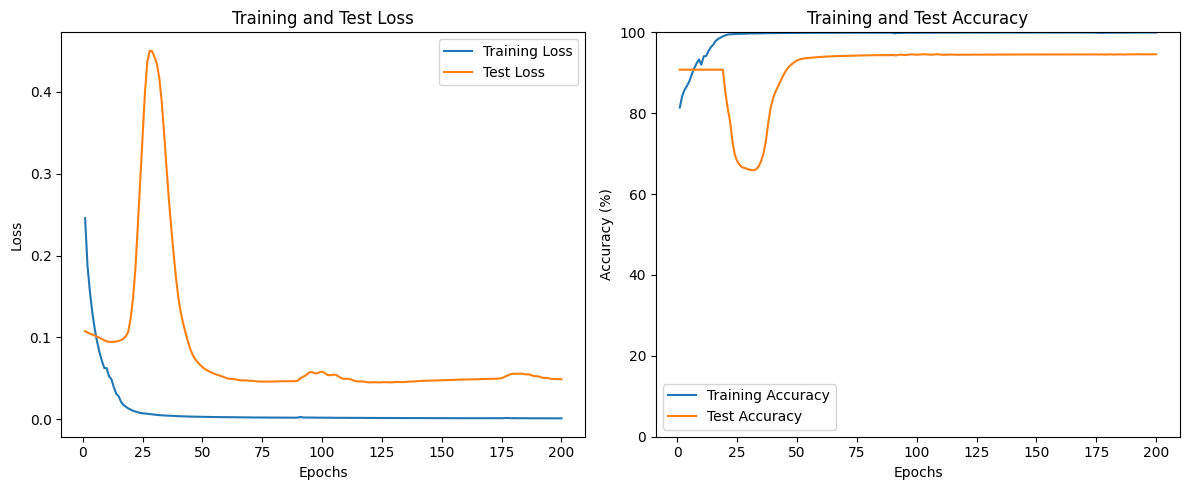

<ipython-input-14-822cbf8f5866>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth"

<All keys matched successfully>

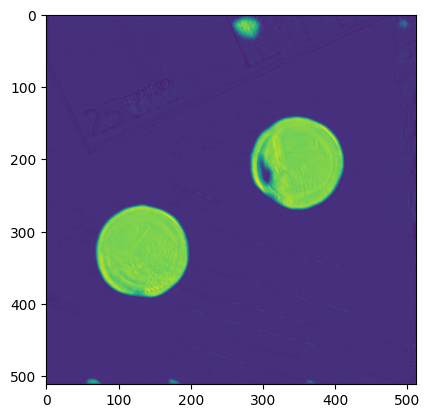

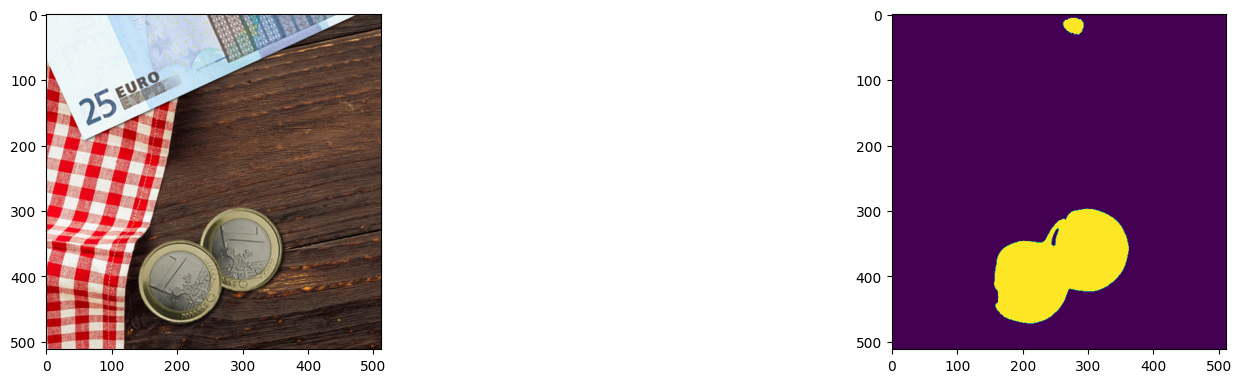

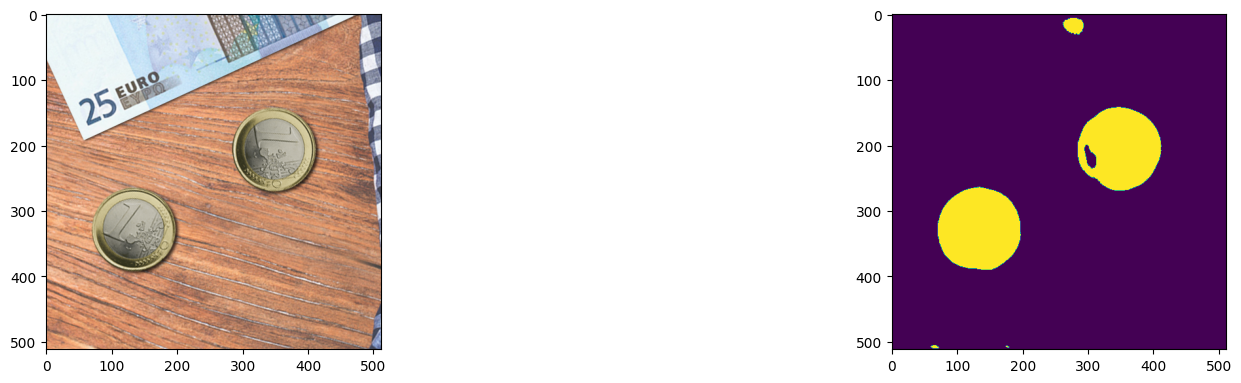

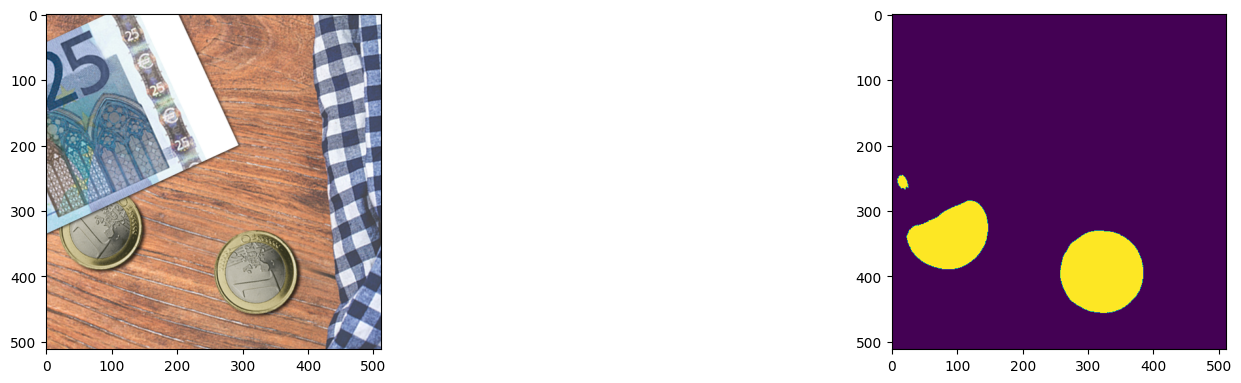

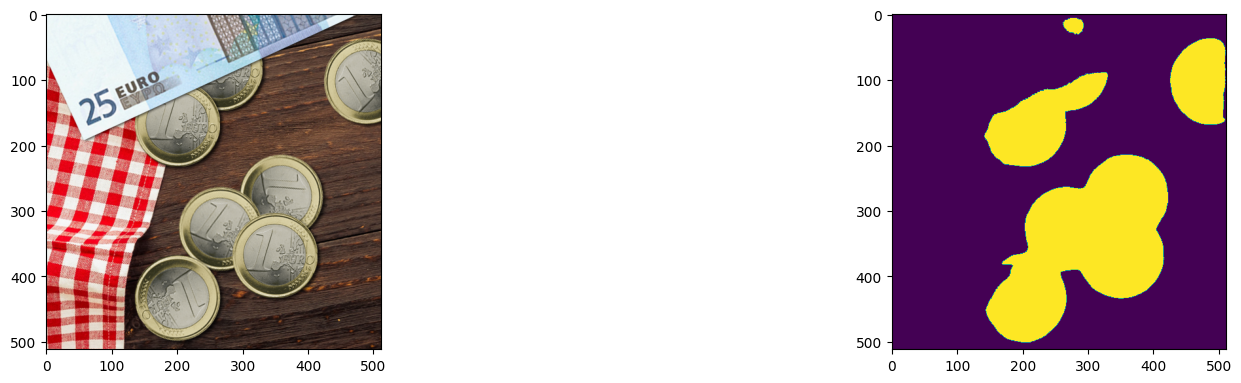

In [14]:
model = build_unet_dynamic(channels=configurations[2],classes=classes).to(device)
y = model(inputs)
print(y.shape)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
trained_model = train_model(model, ds_loader_train, ds_loader_test, criterion, optimizer, [], epochs=200)

it = iter(ds_loader_test)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())


# Threshold the output
ret = torch.round(ret) # redondea para que sea 0 o 1

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())

torch.save(model.state_dict(), "/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth")
model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth"))


torch.Size([2, 1, 512, 512])


<ipython-input-3-e1a416ad69bc>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
<ipython-input-3-e1a416ad69bc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32)


Epoch 1, Training Loss: 0.24504299461841583, Training Accuracy: 79.5374870300293%
Epoch 1, Test Loss: 0.10808269679546356, Test Accuracy: 90.76366424560547%
Epoch 2, Training Loss: 0.19669951498508453, Training Accuracy: 80.80120086669922%
Epoch 2, Test Loss: 0.1088719516992569, Test Accuracy: 90.76366424560547%
Epoch 3, Training Loss: 0.1704462319612503, Training Accuracy: 81.8389892578125%
Epoch 3, Test Loss: 0.10913228988647461, Test Accuracy: 90.76366424560547%
Epoch 4, Training Loss: 0.15382365882396698, Training Accuracy: 82.86170959472656%
Epoch 4, Test Loss: 0.10885617882013321, Test Accuracy: 90.76366424560547%
Epoch 5, Training Loss: 0.14167219400405884, Training Accuracy: 83.68453979492188%
Epoch 5, Test Loss: 0.10894832760095596, Test Accuracy: 90.76366424560547%
Epoch 6, Training Loss: 0.13194948434829712, Training Accuracy: 84.40265655517578%
Epoch 6, Test Loss: 0.11016432195901871, Test Accuracy: 90.76366424560547%
Epoch 7, Training Loss: 0.12373258173465729, Training Ac

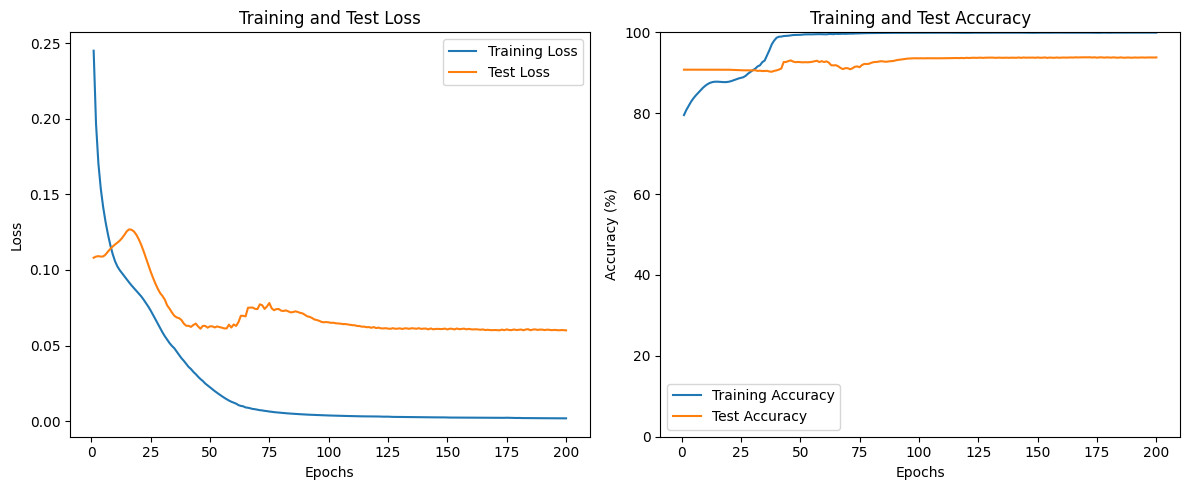

<ipython-input-15-ade160072b21>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth"

<All keys matched successfully>

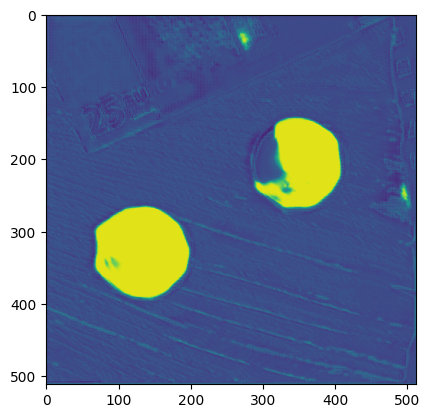

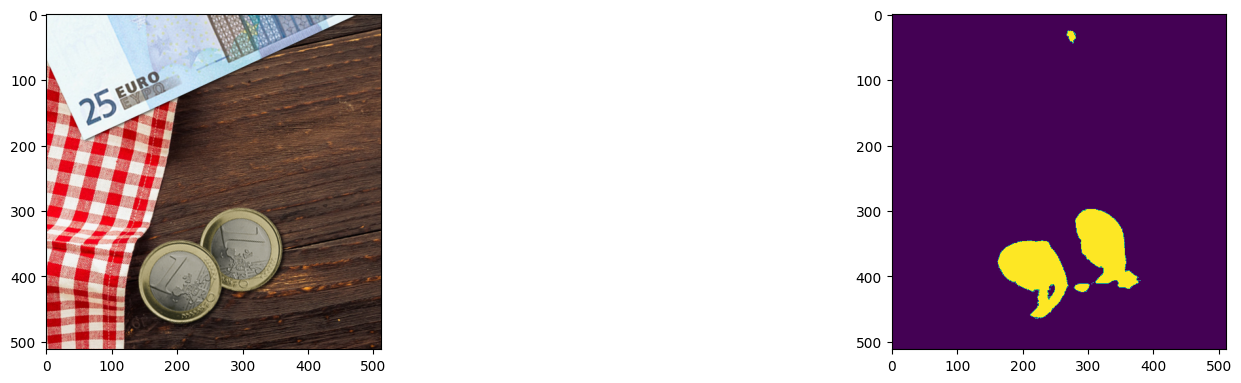

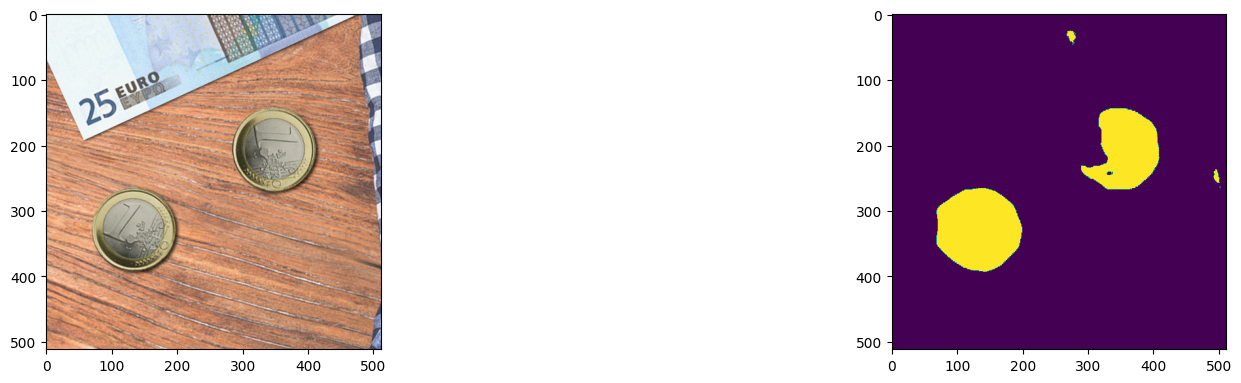

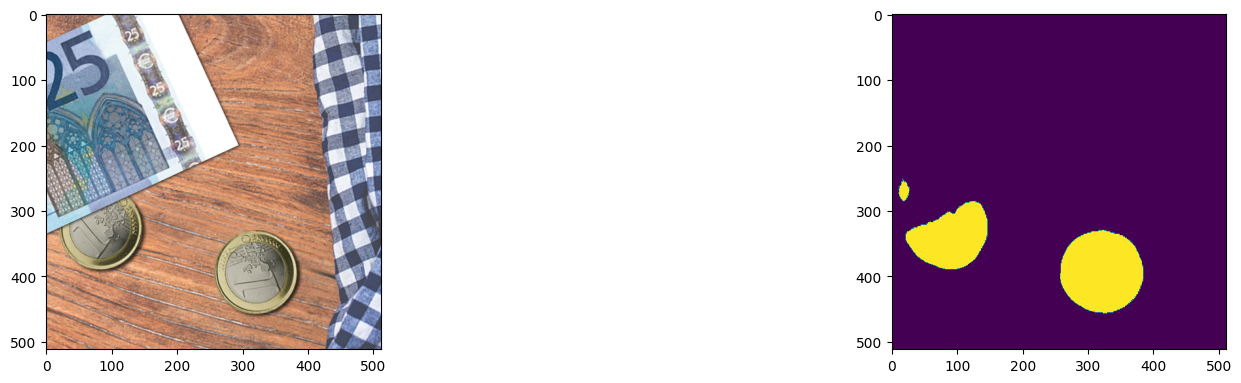

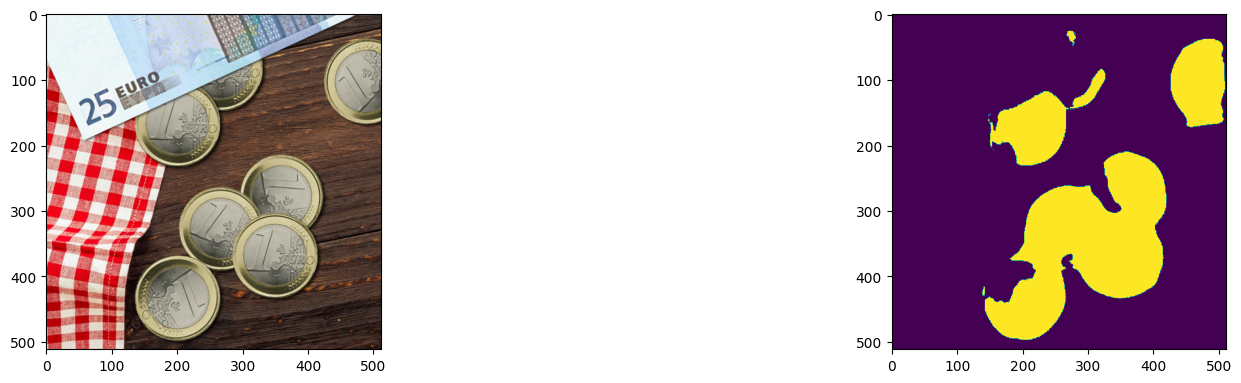

In [15]:
model = build_unet_dynamic(channels=configurations[3],classes=classes).to(device)
y = model(inputs)
print(y.shape)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)
trained_model = train_model(model, ds_loader_train, ds_loader_test, criterion, optimizer, [], epochs=200)

it = iter(ds_loader_test)
img, label = next(it)

model.eval()

ret = model(img.to(device))
plt.imshow(ret[1][0].detach().cpu().numpy())


# Threshold the output
ret = torch.round(ret) # redondea para que sea 0 o 1

# Show a matrix of images of 4x2
for i in range(4):
    # Size image
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0).detach().cpu().numpy())
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(ret[i][0].detach().cpu().numpy())

torch.save(model.state_dict(), "/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth")
model.load_state_dict(torch.load("/content/drive/My Drive/unet/Unet/model_unet_coins_2.pth"))
